In [1]:
# Add PATH (adapt!)
push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/Leaf/");
push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/Utils/");
#push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/tools/");

# Use Plots:
using Plots
#using PhotoStructs
plotly()

┌ Info: For saving to png with the Plotly backend ORCA has to be installed.
└ @ Plots /Users/cfranken/.julia/packages/Plots/NVH6y/src/backends.jl:363


Plots.PlotlyBackend()

In [2]:
using Revise
using CanopyRTMod
using BenchmarkTools
using Statistics

┌ Info: Precompiling CanopyRTMod [top-level]
└ @ Base loading.jl:1260


Reading Optical Parameters from 400.0 to 2380.0 length: 115


In [3]:
wl = CanopyRTMod.wl;
wle = CanopyRTMod.wle;
wlf = CanopyRTMod.wlf;

In [4]:
arrayOfLeaves = Array{leafbio{FT}, 1}(undef, CanopyRTMod.canopy.nlayers)
for i = 1:CanopyRTMod.canopy.nlayers
    arrayOfLeaves[i] = leafbio{FT, length(wl), length(wle), length(wlf)}()
    CanopyRTMod.fluspect!(arrayOfLeaves[i], CanopyRTMod.optis)
end

In [52]:
CanopyRTMod.soil.albedo_SW[:] .=0.1;
@show CanopyRTMod.volscatt(48.0,89,0.1,45)
@show CanopyRTMod.volscatt(48.0,89,360.1,45)
@show CanopyRTMod.volscatt(48.0,89,90,45)
@show CanopyRTMod.volscatt(48.0,89,270,45)
@show cosd(-89)

psi_rad = 0.0017453292519943296
btran1 = 1.1032413936424714
btran2 = 2.003439357115518
CanopyRTMod.volscatt(48.0, 89, 0.1, 45) = (0.4831104164618658, 0.4501581650415133, 0.06612821351992318, 0.00514112254974046)
psi_rad = 6.284930636431581
btran1 = 1.1032413936424714
btran2 = 2.003439357115518
CanopyRTMod.volscatt(48.0, 89, 360.1, 45) = (0.4831104164618658, 0.4501581650415133, 0.06397001667570226, 0.0029829257055195425)
psi_rad = 1.5707963267948966
btran1 = 1.1032413936424714
btran2 = 2.003439357115518
CanopyRTMod.volscatt(48.0, 89, 90, 45) = (0.4831104164618658, 0.4501581650415133, 0.03501511919122603, 0.03315651742621733)
psi_rad = 4.71238898038469
btran1 = 1.1032413936424714
btran2 = 2.003439357115518
CanopyRTMod.volscatt(48.0, 89, 270, 45) = (0.4831104164618658, 0.4501581650415133, 0.03484742334919013, 0.03298882158418142)
cosd(-89) = 0.01745240643728351


0.01745240643728351

In [23]:
reflVIS = []
reflNIR = []
SIF_FR = []
SIF_R  = []
Pso = []
Po = []
Ps = []
ko = []
CanopyRTMod.angles.tts=48
CanopyRTMod.angles.psi=0
CanopyRTMod.canopy.LAI = 2
for VZA=-85:1.01:85
    CanopyRTMod.angles.tto=VZA
    CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt);
    CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);
    CanopyRTMod.computeSIF_Fluxes!(arrayOfLeaves, canOpt, canRad, canopy, CanopyRTMod.soil);
    push!(reflVIS, canRad.alb_obs[28])
    push!(reflNIR, canRad.alb_obs[52])
    push!(SIF_R , canRad.SIF_obs[8])
    push!(SIF_FR, canRad.SIF_obs[20])
    push!(Pso, canOpt.Pso[1])
    push!(Ps, canOpt.Ps[1])
    push!(Po, canOpt.Po[1])
    push!(ko, canOpt.ko[1])
end

In [24]:
VZA=-85:1.01:85
plot(VZA, ko, label="ko")

<!DOCTYPE html>
 
 
 Plots.jl

In [25]:
@show wl[28]
@show wl[52]
CanopyRTMod.angles.tts = 48

plot(VZA, Pso, label="Pso")
plot!(VZA, Po, label="Po")
plot!(VZA, Ps, label="Ps")
#@show wlf

wl[28] = 662.0f0
wl[52] = 817.0f0


<!DOCTYPE html>
 
 
 Plots.jl

In [26]:

plot(VZA, reflVIS, label="Red Reflectance")
plot!(VZA, SIF_FR/100, label="Red SIF")

<!DOCTYPE html>
 
 
 Plots.jl

In [27]:

plot(VZA, reflNIR, label="NIR Reflectance")
plot!(VZA, SIF_FR/5, label="Far Red SIF")

<!DOCTYPE html>
 
 
 Plots.jl

In [32]:
CanopyRTMod.soil.albedo_SW[:] .=0.2;
reflRed_SZA = []
reflNIR_SZA = []
CanopyRTMod.canopy.Ω = 1.0
CanopyRTMod.angles.tto=0.2
CanopyRTMod.canopy.LAI=1.
for SZA=0.0:1:75
    CanopyRTMod.angles.tts=SZA
    CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt);
    CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);
    push!(reflRed_SZA, canRad.alb_direct[28])
    push!(reflNIR_SZA, canRad.alb_direct[52])
end

Ss = 0.0f0
Ss = 0.0f0
Ss = 0.0f0
Ss = 0.0f0
Ss = 0.0f0
Ss = 0.0f0
Ss = 0.0f0
Ss = 0.0f0
Ss = 0.0f0
Ss = 0.0f0
Ss = 0.0f0
Ss = 0.0f0
Ss = 0.0f0


In [33]:
SZA=0:1:75
plot(SZA, reflNIR_SZA)

<!DOCTYPE html>
 
 
 Plots.jl

In [34]:
SZA=0:1:75
plot(SZA, reflRed_SZA)

<!DOCTYPE html>
 
 
 Plots.jl

In [35]:
# Test plots from Christiaan's papers

In [42]:
reflVIS = Float32[]
reflNIR = Float32[]
SIF_FR = Float32[]
SIF_R  = Float32[]
CanopyRTMod.angles.tts=48
CanopyRTMod.angles.psi=0
CanopyRTMod.canopy.LAI=4.22
for psi=0:359
    CanopyRTMod.angles.psi=psi
    for VZA=0:1:85
    CanopyRTMod.angles.tto=VZA
    
    CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt);
    CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);
    CanopyRTMod.computeSIF_Fluxes!(arrayOfLeaves, canOpt, canRad, canopy, CanopyRTMod.soil);
    push!(reflVIS, canRad.alb_obs[28])
    push!(reflNIR, canRad.alb_obs[52])
    push!(SIF_R , canRad.SIF_obs[8])
    push!(SIF_FR, canRad.SIF_obs[20])
    end
end

In [43]:
size(reflNIR)

(30960,)

In [44]:
A = reshape(reflNIR, ( 86,360));
SIFFER = reshape(SIF_R, ( 86,360));
SIFFER_FR = reshape(SIF_FR, ( 86,360));

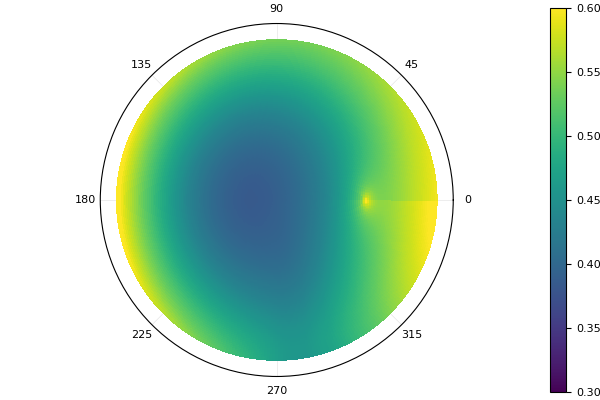

In [45]:
using Plots; pyplot()

#heatmap(A, cmap=)
hm = heatmap(deg2rad.(collect((0:359))),collect(0:1:85),  A,  proj=:polar, color=:viridis,clim=(0.3,0.6))

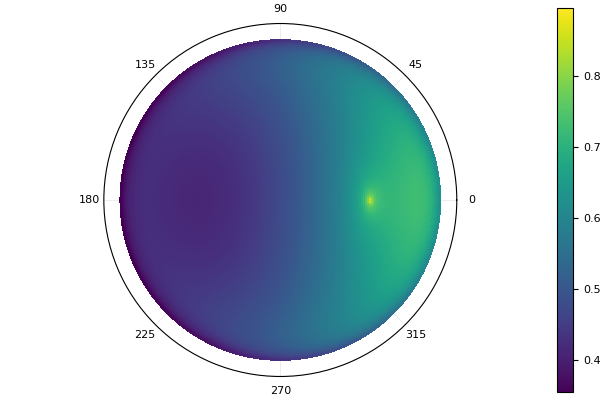

In [46]:
hm = heatmap(deg2rad.(collect((0:359))),collect(0:1:85),  SIFFER, proj=:polar, color=:viridis)

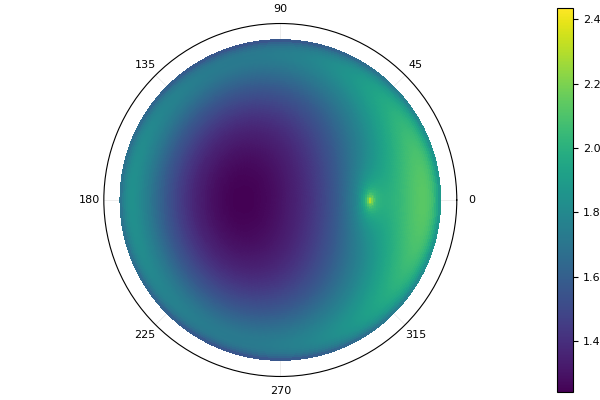

In [47]:
hm = heatmap(deg2rad.(collect((0:359))),collect(0:1:85),  SIFFER_FR, proj=:polar, color=:viridis)

In [20]:
psi

90.0f0